In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from perovskite_data_analysis.common.storage import GoogleDriveStorage
from perovskite_data_analysis.common.credentials import google_credentials

credentials = google_credentials()
storage = GoogleDriveStorage(credentials)

path = 'perovskite/raw/idc2.csv'
df = storage.download_dataframe(path)
df

,Ref_ID,Ref_ID_temp,Ref_name_of_person_entering_the_data,Ref_data_entered_by_author,Ref_DOI_number,Ref_lead_author,Ref_publication_date,Ref_journal,Ref_part_of_initial_dataset,Ref_original_filename_data_upload,...,Outdoor_spectral_data_available,Outdoor_link_spectral_data,Outdoor_irradiance_measured,Outdoor_link_irradiance_data,Tolerance factor,TS80,Atemperature,Ahumidity,Alight,TS80m
0,16,16,Adam Hultqvist,False,10.1007/s10118-017-1891-z,Chen et al.,2016/12/29,Chinese Journal of Polymer Science,True,Historic dataset on 2020 11 22_v7.xlsx,...,False,NaN,False,NaN,0.911521,NaN,NaN,NaN,NaN,NaN
1,17,17,Adam Hultqvist,False,10.1007/s10118-017-1891-z,Chen et al.,2016/12/29,Chinese Journal of Polymer Science,True,Historic dataset on 2020 11 22_v7.xlsx,...,False,NaN,False,NaN,0.911521,NaN,NaN,NaN,NaN,NaN
2,26,26,Adam Hultqvist,False,10.1016/j.electacta.2017.12.108,Cai et al.,2017/12/19,Electrochimica Acta,True,Historic dataset on 2020 11 22_v7.xlsx,...,False,NaN,False,NaN,0.911521,220.00000,0.855491,1.70,0.199526,63.839170
3,27,27,Adam Hultqvist,False,10.1016/j.electacta.2017.12.108,Cai et al.,2017/12/19,Electrochimica Acta,True,Historic dataset on 2020 11 22_v7.xlsx,...,False,NaN,False,NaN,0.911521,350.00000,0.855491,1.70,0.199526,101.562315
4,28,28,Adam Hultqvist,False,10.1039/c9ta01893j,Zhang et al.,2019/3/20,Journal of Materials Chemistry A,True,Historic dataset on 2020 11 22_v7.xlsx,...,False,NaN,False,NaN,0.968626,200.00000,0.855491,2.00,1.000000,342.196543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7414,15535,15535,Isaac Gould,False,10.1021/acsami.8b16601,Lin et al.,2018/11/8,ACS Applied Materials & Interfaces,True,Historic dataset on 2020 11 22_v7.xlsx,...,False,NaN,False,NaN,0.911521,72.00000,1.829510,4.00,0.199526,105.130037
7415,15539,15539,Isaac Gould,False,10.1021/acsami.8b16601,Lin et al.,2018/11/8,ACS Applied Materials & Interfaces,True,Historic dataset on 2020 11 22_v7.xlsx,...,False,NaN,False,NaN,0.911521,2192.57000,1.829510,1.50,0.199526,1200.546693
7416,10499,10499,Gabriella Stephania Anaya Gonazalez,False,10.1021/acsenergylett.9b00403,Jiang et al.,2019/5/2,ACS Energy Letters,True,Historic dataset on 2020 11 22_v7.xlsx,...,False,NaN,False,NaN,NaN,40.00000,43.280500,1.00,0.199526,345.423635
7417,16307,16307,Jacob Vagott,False,10.1039/c7ta01718a,Rakstys et al.,2017/3/29,Journal of Materials Chemistry A,True,Historic dataset on 2020 11 22_v7.xlsx,...,False,NaN,False,NaN,NaN,101.40700,0.855491,1.00,1.000000,86.752812


### General check - dtypes, nulls and info


In [3]:
# remove redundant columns
redundant_columns = ["Ref_ID", "Ref_ID_temp", "Ref_name_of_person_entering_the_data", "Ref_data_entered_by_author",
                     "Ref_DOI_number", "Ref_lead_author", "Ref_publication_date", "Ref_journal",
                     "Ref_part_of_initial_dataset", "Ref_original_filename_data_upload", ]
df = df.drop(columns=redundant_columns)

In [4]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7419 entries, 0 to 7418
Data columns (total 404 columns):
 #    Column                                                           Non-Null Count  Dtype  
---   ------                                                           --------------  -----  
 0    Cell_stack_sequence                                              7419 non-null   object 
 1    Cell_area_total                                                  176 non-null    float64
 2    Cell_area_measured                                               7243 non-null   float64
 3    Cell_number_of_cells_per_substrate                               7419 non-null   int64  
 4    Cell_architecture                                                7419 non-null   object 
 5    Cell_flexible                                                    7419 non-null   bool   
 6    Cell_flexible_min_bending_radius                                 0 non-null      float64
 7    Cell_semitransparent           

In [5]:
# get total null values
total_null_cols = [
    col for col in df.columns if df[col].isna().all()
]
print("Total null columns: ", len(total_null_cols))
df.drop(columns=total_null_cols, inplace=True)

Total null columns:  46


Partial null columns:  179


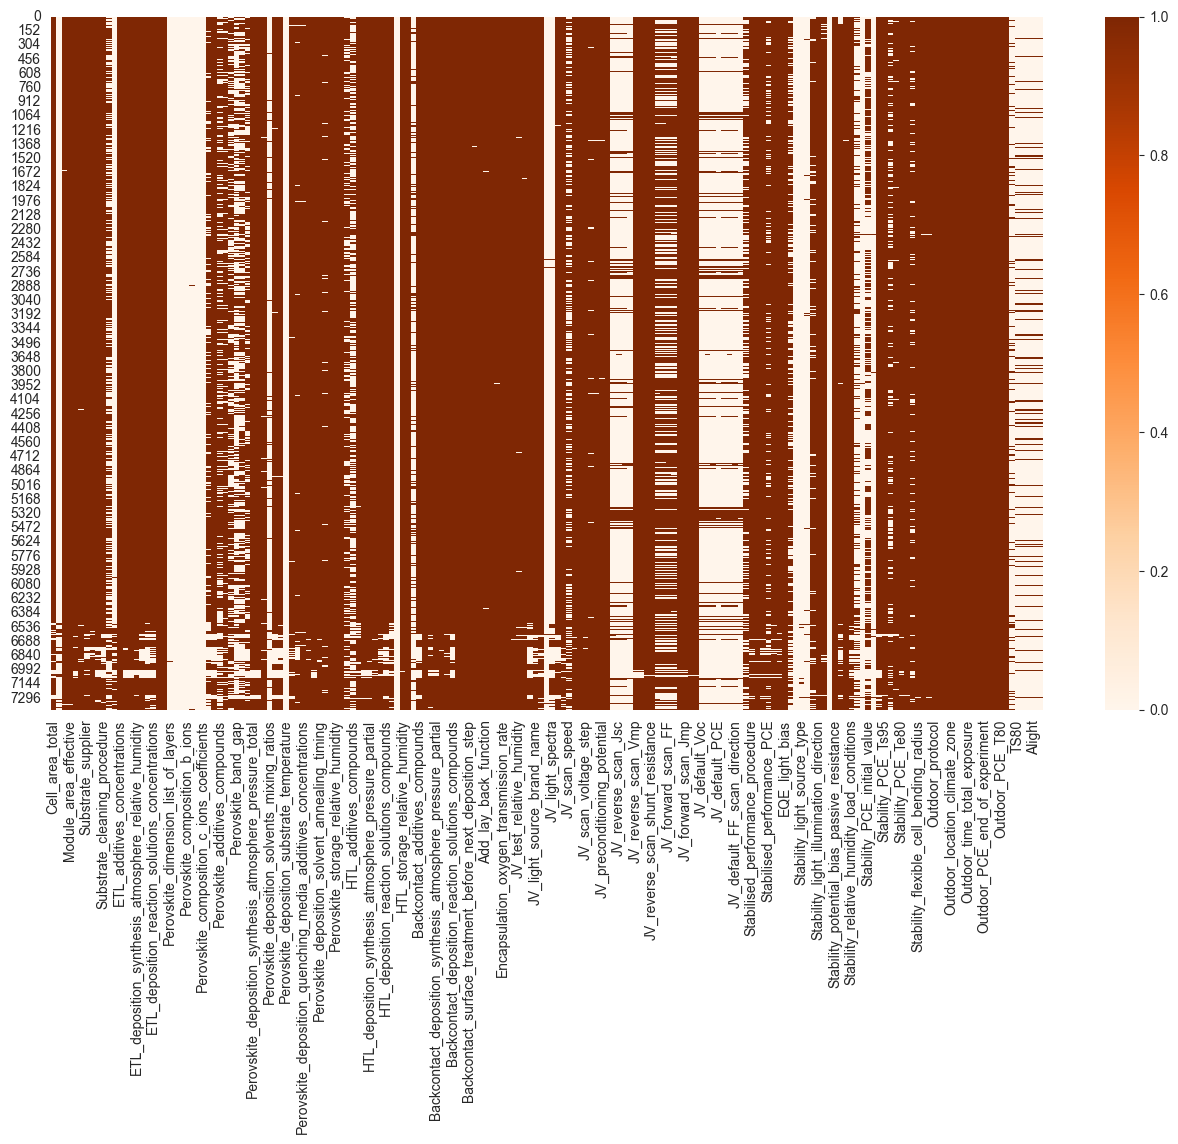

In [6]:
# check partial columns
partial_null_cols = [
    col for col in df.columns if df[col].isna().any()
]
print("Partial null columns: ", len(partial_null_cols))
plt.figure(figsize=(16, 9))
sns.heatmap(df[partial_null_cols].isna(), cmap='Oranges', )
plt.show()

In [7]:
# determine null threshold if column null values are above this or equals drop column
null_threshold = int((df.shape[0] * 90) / 100)
print("Null threshold: ", null_threshold)
threshold_cols = [col for col in df.columns if df[col].isna().sum() >= null_threshold]
print("Threshold columns: ", len(threshold_cols))
df.drop(columns=threshold_cols, inplace=True)

Null threshold:  6677
Threshold columns:  118


#### Filter non obvious nulls (non atomic data cells, unknown values)

In [8]:
non_atomic_columns_null = ["Cell_semitransparent_wavelength_range", "Outdoor_location_coordinates", "Stability_potential_bias_range", "Outdoor_potential_bias_range", "Outdoor_temperature_range", "JV_light_wavelength_range"]

print("Non atomic column nulls", df[df["Cell_semitransparent_wavelength_range"] == "nan; nan"].shape)
print("Non atomic column nulls", df[df["Outdoor_location_coordinates"] == "nan; nan"].shape)
print("Non atomic column nulls", df[df["Stability_potential_bias_range"] == "nan; nan"].shape)
print("Non atomic column nulls", df[df["Outdoor_potential_bias_range"] == "nan; nan"].shape)
df.drop(columns=["Cell_semitransparent_wavelength_range", "Outdoor_location_coordinates", "Stability_potential_bias_range"], inplace=True)

Non atomic column nulls (7419, 240)
Non atomic column nulls (7419, 240)
Non atomic column nulls (7383, 240)
Non atomic column nulls (7419, 240)


In [9]:
unknown_values_cols = [
    col for col in df.columns if "Unknown" in df[col].unique()
]
unknown_threshold_cols = [
    col for col in df.columns if df[df[col] == "Unknown"].shape[0] >= null_threshold
]
print("Unknown columns: ", len(unknown_threshold_cols))
df.drop(columns=unknown_threshold_cols, inplace=True)

Unknown columns:  107


In [10]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7419 entries, 0 to 7418
Data columns (total 130 columns):
 #    Column                                                          Non-Null Count  Dtype  
---   ------                                                          --------------  -----  
 0    Cell_stack_sequence                                             7419 non-null   object 
 1    Cell_area_measured                                              7243 non-null   float64
 2    Cell_number_of_cells_per_substrate                              7419 non-null   int64  
 3    Cell_architecture                                               7419 non-null   object 
 4    Cell_flexible                                                   7419 non-null   bool   
 5    Cell_semitransparent                                            7419 non-null   bool   
 6    Module                                                          7419 non-null   bool   
 7    Module_number_of_cells_in_module        

In [11]:
# drop columns based on info
cols_to_drop = ["ETL_thickness", "Perovskite_composition_none_stoichiometry_components_in_excess",
                "Perovskite_additives_compounds", "Perovskite_additives_concentrations", "Perovskite_pl_max",
                "JV_forward_scan_Voc", "JV_forward_scan_Jsc", "JV_forward_scan_FF", "JV_forward_scan_FF",
                "Stabilised_performance_PCE", "EQE_integrated_Jsc",
                "Stability_PCE_initial_value", "Stability_PCE_T80", "Stability_PCE_after_1000_h"]
df.drop(columns=cols_to_drop, inplace=True)

In [12]:
df["Perovskite_composition_a_ions"]

0                    MA
1                    MA
2                    MA
3                    MA
4            Cs; FA; MA
             ...       
7414                 MA
7415                 MA
7416    BA; FA; MA; PMA
7417             FA; MA
7418                 FA
Name: Perovskite_composition_a_ions, Length: 7419, dtype: object

In [13]:
df['Perovskite_composition_b_ions']

0       Pb
1       Pb
2       Pb
3       Pb
4       Pb
        ..
7414    Pb
7415    Pb
7416    Pb
7417    Pb
7418    Pb
Name: Perovskite_composition_b_ions, Length: 7419, dtype: object

0       1
1       1
2       1
3       1
4       1
       ..
7414    1
7415    1
7416    1
7417    1
7418    1
Name: Stability_average_over_n_number_of_cells, Length: 7419, dtype: int64

In [18]:
df["Stability_protocol"]

0        ISOS-L-1
1        ISOS-L-1
2        ISOS-D-1
3        ISOS-D-1
4        ISOS-L-1
          ...    
7414     ISOS-D-1
7415     ISOS-D-1
7416    ISOS-D-2I
7417    ISOS-L-1I
7418     ISOS-D-1
Name: Stability_protocol, Length: 7419, dtype: object